### 渋滞解消の最適化問題

量子アニーリングマシンの実応用例としてバイブル的存在なのがVolkswagenによる渋滞解消の最適化問題でしょう。
この問題について、実装をするプログラムを紹介しながら解説します。

まず先にどのような最適化問題であったか、そのコスト関数を紹介します。
車が複数台いて、その車には予定している経路のパターンがいくつかあるという状況を考えます。
もちろんその経路パターンは、出発地（現在地）から目的地までの最短経路を含みます。
効率重視でも良いですが、他の車との遭遇を考えると、渋滞の可能性がありますので、その遭遇を避けるような最適化を実施することが望まれます。
そこで車は複数の経路パターンの中から全体にとって最適なものを選ぶようにしましょう。
そういう問題設定です。

ある車$i$に対して$k$番目の経路パターンを選ぶかどうかを$x_{ik}$を利用して表しましょう。
選ぶときは$x_{ik} = 1$、選ばないときは$x_{ik}=0$とします。
それぞれの車は経路を1つしか選ばないのだから
\begin{equation}
\sum_{k=1}^K x_{ik} = 1
\end{equation}
という等式制約が成り立ちます。
ここでは各車に$K$個の経路パターンが用意されていると想定しています。

これは罰金法を利用してあげれば、この条件を要求することはこれまで通りできそうですね。
2つの添字があってもpyQUBOがあれば安心と思いますよね。
ただ問題によっては自由自在にこの添字を扱えるようにしておくと良いこともあります。
2つの添字を1つの添字のように扱うテクニックがあります。

$k$は$1,2,3,\ldots,K$までですが、そのまま続けて$K+1,K+2,K+3,\ldots,2K$と数字を並べてみましょう。
1台目の経路は$1,2,3,\ldots,K$で表し、2台目の経路を$K+1,K+2,K+3,\ldots,K$で表すことにしてみてはどうでしょうか。
通し番号を利用するのです。
そうすると文字がひとつだけど、$i$台目の$k$番目の経路パターンという指定の仕方が可能となります。
ひとまとめにした添字を$m$としましょう。
その添え字と$i$と$k$の関係は
\begin{equation}
m = k + K*i
\end{equation}
となります。
これを利用すると$x_{i,k}=x_m$と書き換えることができます。

こうした制約条件に対して、コスト関数は、ある経路$m$について、道路$e$を通るかどうかを示す$C_{e,m}$を用意します。この$C_{e,m}$は$0$または$1$を持ち、道路$e$を通る場合は$C_{e,m}=1$、道路$e$を通らない場合は$C_{e,m}=0$とします。

これを用いて次のようなコスト関数を考えます。
\begin{equation}
E(x) = \sum_{e} \left( \sum_{m} C_{e,m} x_m \right)^2 + \lambda \sum_{i=1}^N \left( \sum_{k=1}^K x_{ik} - 1 \right)^2
\end{equation}


第二項は罰金法により、等式制約を課したものです。
そして第一項が、渋滞解消のために、道路$e$ごとに考えて計算されたコストです。
道路$e$を何台の車が通るかを調べて、それを二乗してコスト関数に組み込んでいます。

道路$e$を車が通った台数を調べるには、全ての経路パターンについて足し上げて、その経路パターンが選ばれているかどうかを確認すれば良いので$x_{m}$をかけます。
それを二乗すれば、台数が増えれば増えるほど、コスト関数が上昇しますので、最小化をすることにより、できるだけ同じ道路を通る車の台数を減らすようになります。
そうすることで平均化されることで渋滞が解消されると考えたわけです。

### 渋滞解消のQUBOの作成に向けて

さて今回はそうしたバイブル的存在のVolkswagenの応用例を実装することで、
本格的に利用できるアプリケーションを作るというのはどういうことかを体験してもらいます。

上記のように最適化するべきコスト関数は比較的早期に思いつくものですが、
それで実際に量子アニーリングマシンに投じるためには、いくつかの前処理を実行する必要があります。
データの取得、加工などその前処理に時間がかかりますので、なかなか根気が入りますが、
こういう流れで計算をしているのだ、ということを感じてもらいたいと思います。

今回は最初に読み込むのが地図情報関連のものです。
実際にVolkswagenの研究でも利用されたosmnxです。

まずこちらはpip installでインストールから始めます。
ご自身の環境にインストールする場合はターミナル上で以下のコードを。
Google colab上で利用される場合はそのまま以下のコードを。

In [ ]:
pip install osmnx

  Using cached https://files.pythonhosted.org/packages/24/33/5568d443ba438d95d4db635dd69958056f087e57e1026bee56f959d53f9d/matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


多少の警告文章が出ますが、そのまま行きますね。
ご自身の環境でやる場合は、仮想環境を用意した上でやると良いです。
なかなか既存の環境でうまくいくということがない、非常に難易度の高い操作になります。

いつも利用しているmatplotlibについては、ver違いで後々に描画でエラーが出ることがあります。
Google colab上ではまずこちらのコードを打ってください。


In [ ]:
pip install matplotlib==3.1.3

  Using cached https://files.pythonhosted.org/packages/4c/9b/35ab3469fd1509f7636a344940569ebfd33239673fd2318e80b4700a257c/matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl
ERROR: osmnx 1.1.1 has requirement matplotlib>=3.3, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.4.2
    Uninstalling matplotlib-3.4.2:
      Successfully uninstalled matplotlib-3.4.2


いつも読み込む計算用のライブラリのnumpyとともにmatplotlib.pyplotを読み込みましょう。

In [ ]:
import numpy as np
from matplotlib import pyplot as plt 


準備ができたらimport osmnxで利用できるように準備をします。

In [ ]:
import osmnx as ox

これを利用すると容易に地図情報、とりわけ道路情報を読み出すことができます。

まずはどの範囲の情報が欲しいのかということを、北端、南端、東端、西端を緯度軽度で指定します。

In [ ]:
#宮城県
mr = {
    'north': 38.337173, 'south': 38.323690,
    'east': 141.051547, 'west': 141.025454
}

だいたい経度1度分が北緯35度上では91kmほどです。非常に広い範囲となります。
北に行くにつれてだんだんとその距離は短くなっていきますので、参考程度です。

もしも緯度経度を調べるのが億劫だとなった場合には。
以下のコードでgeocoderを用意してください。

In [ ]:
pip install geocoder

In [ ]:
import geocoder as geo
geo_address = '東京都品川区'

geo_location = geo.osm(geo_address)
lat = geo_location.latlng[0]
lng = geo_location.latlng[1]

mr = {
    'north': lat + 0.01, 'south': lat - 0.01,
    'east': lng + 0.01, 'west': lng - 0.01
}

これにより緯度経度を地名から取り出すgeo.osm()という関数を利用することができます。
それで得られたgeo_locationから緯度（lat）経度（lng）を取り出しています。

次は試しに道路地図を表示してみましょう。
mrにより指定された端をもとに地図を取り出すのが次のコードです。

In [ ]:
G = ox.graph_from_bbox(mr['north'], mr['south'], mr['east'], mr['west'], network_type='drive')

結果を表示するためには、次のコードを打つだけです。
plot_graphです。

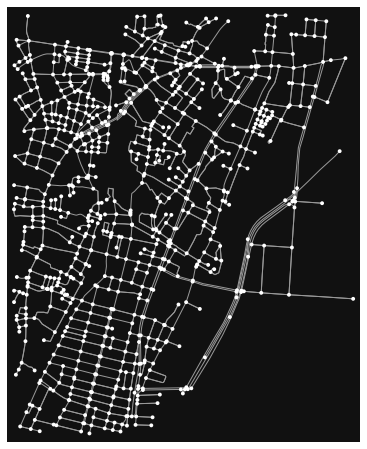

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdb039cb8d0>)

In [ ]:
ox.plot_graph(G)

得られた地図が、だいたいどこのものかを確認してください。
希望通りの場所の様子が描かれているでしょうか。


### OSMNXを用いた経路生成

次に出発地点や目的地点の参考とするために点情報を抜き出します。

In [ ]:
node_list = []
for key in G.nodes(data=False):
    node_list.append(key)

このnode_listには、地点を示す番号（ID）のリストがずらっと並んでいます。
この番号を選ぶことによって、出発地点や目的地点を指定することにします。

このデータは、[]で初期化したリストという形式で格納しています。
どれだけの地点があるのか調べるには、リストの長さを調べるlen()という関数を利用することで実行できます。

In [ ]:
print(len(node_list))

861


In [ ]:
node_list_perm = np.random.permutation(node_list)

次にこれをランダムシャッフルすることにしましょう。numpyのrandom.permutation（ランダム順列）を利用することで順番をバラバラにします。
これから出発地点（車が現在いるところ）と、目的地点（車が向かうところ）を得ることにしましょう。

車の台数を指定して、その台数分の出発地点と目的地点をnode_list_permから取り出します。
car_nの大きさは、node_listを参考に決めてください。
num_routeはそれぞれの車に対して用意する経路パターンの数です。

In [ ]:
car_n = 10
num_route = 3
N = car_n*num_route

start_list = node_list_perm[0:car_n]

次に目的地点を用意しましょう。本来であればそれは指定されているはずですが、ここでは適当な決め方でとりあえずのデータを作る必要があります。
出発地点から必ずしも到達可能かどうかが不明ですので、それを調べながら出発地点の選定をします。

これにはnetworkXというグラフ関連のアルゴリズムが豊富に格納されているライブラリを利用します。

Google colabでは幸いすでに用意されている様子です。
ご自身の環境で利用される場合には、pip install networkXを実行してください。
そのあとでimport networkxです。

In [ ]:
import networkx as nx

準備完了です。それでは順々に目的地点を用意しましょう。

In [ ]:
n = 0
end_list = []

while len(end_list) < car_n:
  k = len(end_list)
  cand = node_list_perm[car_n+k+n]
  check = nx.has_path(G,start_list[k],cand)
  if check == 1:
    end_list.append(cand)
  else:
    n = n + 1

多少長めのコードになりましたが、一つ一つみていくと、end_list = []で最初空のリストを用意します。
このリストに新しい要素を追加するためには、リストのデータに.append()として、追加したい要素を入れていきます。
それはcandということで最後に追加しているのが見えますね。

これはnode_list_permでstart_listに使ったcar_n分の次から取り出しています。
while文をここでは利用しています。
英語でwhileは、何々である間は続くという意味です。
ここではlen(end_list)がcar_nに満たない間は続けようという意味です。
whileに続く条件が成立している間はいかに続くコードを繰り返しましょうということです。

回数を指定せずに、繰り返して欲しいという意味でfor文と似ていますが、使いどころが異なります。
数学で不等式を学んだ理由がここでじわじわと出てくることでしょう。

k=len(end_list)で何番目のnodeを利用するかがシフトしていきます。

cand = node_list_perm[car_n+k+n]で最初に利用したcar_nから続いてk番目の地点を使いましょうという意味になります。

nは後々に出てくるように、もしも出発地点start_list[k]と、candを繋ぐ経路がなければ、別の目的地を探してもらうためのずらしを与える数字です。
下に出てくるif文で、もしもうまく条件に見合うものがなければ、elseで、n=n+1としてずらし方を増やしていますね。

checkにはnx.has_path()という関数で、start_list[k]とcandの間に経路が存在しない場合には、0(False)、存在する場合には1(True)という値が入るようになります。

これで準備完了。if文でcheck==1とありますように、
もしもcheck=1であれば、candを目的地のリストに組み込みます。
逆にcheck=1でない、ここではcheck=0であればelse文の方に分岐します。

ゆっくり読んで理解しながらコードを実行しましょう。

さあ次は、こうして得られた2地点間の最短経路を探索するプログラムを用意しましょう。
ここでは量子アニーリングマシンを使うわけではありません。
全ての最適化問題に量子アニーリングマシンを使おうとしないでくださいね。
ここぞ、というときに使うのがポイントです。

networkxに最短経路を求める関数が既に用意されています。
nx.shortest_path()という関数です。
残念なことに最短経路を準備することはできても、ちょっと長い経路などを作る有り合わせの関数は存在しません。
そこで自分で作っておく必要があります。
経路として採用された道路は擬似的に非常に長い道のりを持つ道路へと変更されることにします。
次のような関数を作りましょう。

In [ ]:
def penalty(G,route,pen):
    for k in range(len(route)-1):
        i = route[k]
        j = route[k+1]
        G[i][j][0]['length'] += pen
    return G

ここで自作の関数を作りました。defとした後に関数の名前をうち、利用する変数を指定して自作の関数を作ることができます。routeというリストは、順々にどこの地点を巡るかを並べたリストとなる想定でいます。
route[k],route[k+1]で、順々にどこを経めぐるのかを調べ、その間の距離を示すF[i][j][0]["length"]にpen分追加するという関数です。
こうすることにより、一度通ったところは、pen分だけ擬似的に距離を伸ばして、もう一度通ることを好ましくないようにしておきます。
その上でnx.shortest_path()関数を利用すれば、先ほどの通った道をできるだけ通らないようにした別の最短経路を求めてくれます。
これを3回繰り返して、
同じ出発地と目的地を使い、異なる経路パターンを3つ作ります。
最後にグラフの距離をもとに戻してあげておきましょう。

In [ ]:
route_list = []
for k in range(car_n):
    start_key = start_list[k]
    end_key = end_list[k]
    shortest_route1 = nx.shortest_path(G, start_key, end_key, 'length')
    route_list.append(shortest_route1) 
    G = penalty(G,shortest_route1,200)
    
    shortest_route2 = nx.shortest_path(G, start_key, end_key, 'length')
    route_list.append(shortest_route2) 
    G = penalty(G,shortest_route2,200)

    shortest_route3 = nx.shortest_path(G, start_key, end_key, 'length')
    route_list.append(shortest_route3) 
    G = penalty(G,shortest_route3,200)
    
    #長くした距離を戻す
    G = penalty(G,shortest_route1,-200)
    G = penalty(G,shortest_route2,-200)
    G = penalty(G,shortest_route3,-200)

route_listには車の台数car_nにそれぞれ3個ずつの経路パターンが格納されています。
これからQUBO行列を作ることができます。

その前にせっかくですから、どんな経路パターンが作られたのか、全て並べてみてみましょう。
osmnxからplot_graph_routes()を利用します。

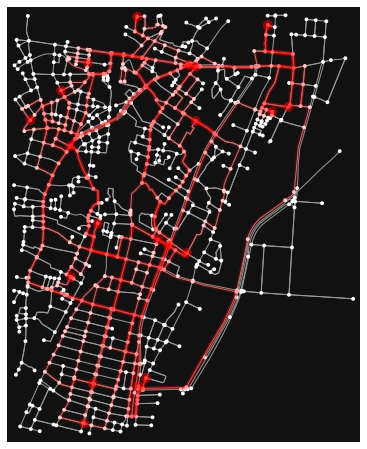

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdb04240590>)

In [ ]:
ox.plot_graph_routes(G, route_list, route_alpha=0.2)

多くの赤い経路が地図上で表示されたかと思います。
一つ一つの経路を描きたい場合は、route_list[k]として、選んで描画しましょう。
このときは、osmnxのplot_graph_route()を利用します。

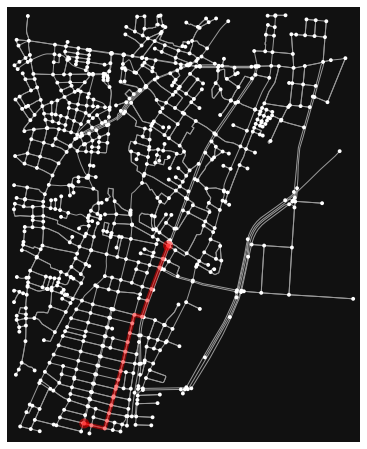

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdb03e50b10>)

In [ ]:
ox.plot_graph_route(G, route_list[0])

同じ車で違う経路を見てみると出発地、目的地を共有していることがわかるかと思います。

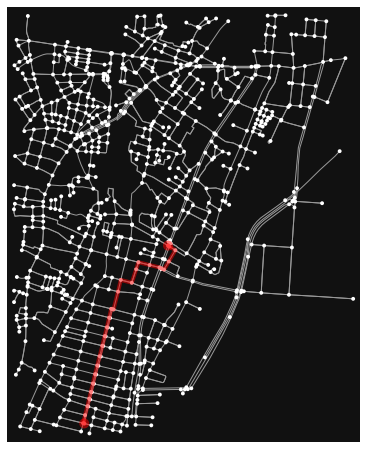

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdb039318d0>)

In [ ]:
ox.plot_graph_route(G, route_list[1])

### 経路パターンからQUBO行列の作成

次に用意するのは各道路$e$について、ある経路$i,k$（車$i$が選ぶ$k$番目の経路）、つまり$m$を通るか通らないかを示したものが$C_{e,m}$でした。
道路$e$を通る場合には$1$、通らない場合には$0$とします。


残念ながら経路パターンに含まれる道路は（route[l],route[l+1]）という形で指定するしかないので、行列の形を作るには不向きです。$e$という添え字に相当する番号を割り振る必要があります。
そこで次のように番号を振っていきます。


In [ ]:
edge_dict = {}
k = 0
for route in route_list:
  for l in range(len(route)-1):
    e = (route[l],route[l+1])
    if e not in edge_dict.keys():
      edge_dict[e] = k 
      k = k + 1

まずedge_dictという空のdict形式のデータを用意します。
これには(route[l],route[l+1])という形式で道路を指定したときに、それが何番目の道路かという番号を教えてくれるデータです。(route[l],route[l+1])->$e$という変換をするイメージです。

そのためにroute_listに含まれる経路パターンをrouteとして1つ1つ取り出してfor文で繰り返して続きの計算を実行します。
routeに含まれる通過点を(route[l],route[l+1])というペア、つまり道路を示す辺（edge）として取り出し、edge_dictに過去存在しなかったものの場合は（e not in edge.keys()）、辞書に登録をするというコードとなっている。この際に何番目の道路かというのをkにより示し、次に行くときにはk = k+1と更新されるようにしています。



これを利用すると、行列$C_{e,m}$は次のように準備をすることができます。

In [ ]:
C = np.zeros(N*len(edge_dict)).reshape(len(edge_dict),N)
for i in range(car_n):
  for k in range(num_route):
    m = k+i*num_route
    p = route_list[m]
    for l in range(len(p)-1):
      e = edge_dict[(p[l],p[l+1])]
      C[e,m] = 1

どんな行列かをみたい場合には、imshow()で表示しましょう。

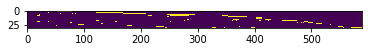

In [ ]:
plt.imshow(C.T)
plt.show()

これで準備完了です。
QUBO行列を考えてみましょう。
まず第一項は$\sum_e \left( \sum_m C_{e,m}x_{e,m} \right)^2$でした。
展開してみると、
\begin{equation}
\sum_e \left( \sum_m C_{e,m} x_{m} \right)^2 = \sum_e \left( \sum_m C_{e,m} x_{m} \right)\left( \sum_n C_{e,n} x_{n} \right) = \sum_{m,n} \sum_e C_{e,m} C_{e,n} x_{m} x_{n}
\end{equation}
このような形を持つ。
第一項に関係するQUBO行列はeに関する和を計算すれば良いことがわかる。
そうした計算は以下の内積によって計算することができます。

In [ ]:
Q1 = np.dot(C.T,C)

さらに第二項については、シグマ記号はfor文であるということを思い出せば自力でも書くことができます。
\begin{equation}
\lambda \sum_{i=1}^N \left( \sum_{k=1}^K x_{ik} -1 \right)^2 = \lambda \sum_{i=1}^N \left( \sum_{k=1}^K x_{ik} -1 \right)\left( \sum_{l=1}^K x_{il} -1 \right)
\end{equation}
ひとつひとつ展開をしてばらせば、
\begin{equation}
\lambda \sum_{i=1}^N \left( \sum_{k=1}^K x_{ik} -1 \right)^2 = \lambda \sum_{i=1}^N \sum_{k=1}^K \sum_{l=1}^K x_{ik}  x_{il} -2 \lambda\sum_{i=1}^N\sum_{k=1}^K x_{ik}+ \lambda KN
\end{equation}
となります。最後の定数は放っておいて、$x_{ik}$がかかっているところだけに注目します。



In [ ]:
Q2 = np.zeros(N**2).reshape(N,N)

for i in range(car_n):
  for k in range(num_route):
    for l in range(num_route):
      m1 = k + i*num_route
      m2 = l + i*num_route
      Q2[m1,m2] = Q2[m1,m2] + 1.0
      if m1 == m2:
        Q2[m1,m2] = Q2[m1,m2] -2.0

これらをまとめてQUBO行列とするわけですが、今後大量の車及び移動体を相手に同種のアプリケーションを開発する際には、QUBO行列が巨大になるということが懸念されます。
そうしたときは、少なくともdict形式に直し、QUBO行列のうち$0$である成分は送信しないようにしましょう。

In [ ]:
lam = 60.0
Q = Q1 + lam*Q2

Qdict = {}
for m in range(N):
  for n in range(N):
    if Q[m,n] != 0.0:
      Qdict[m,n] = Q[m,n]

これで量子アニーリングマシンに投入する準備が整いました。
長かかったですね。
これは完成品を実装するだけで良かったのでできたことですが、実際の開発では試行錯誤の連続で、一筋縄ではいきません。
それでも諦めずに新しい応用例を考えてみましょう！

### ついに量子アニーリングマシンに投入！

さあこのあとはいつもの通りの流れですね。D-Wave Ocean SDKを準備しましょう。

In [ ]:
pip install dwave-ocean-sdk

API tokenと接続先エンドポイントもいつも通り。

In [ ]:
token = '**'
endpoint = 'https://cloud.dwavesys.com/sapi/'

D-Wave Advantage等のQPUをソルバーに選びましょう。

In [ ]:
from dwave.system import DWaveSampler, EmbeddingComposite

dw_sampler = DWaveSampler(solver='Advantage_system1.1', token=token)
sampler = EmbeddingComposite(dw_sampler)

あとは用意したQUBO行列を送るだけです。
投げることができるようになっても意味がないことがこれで身に染みてわかったことでしょう。

In [ ]:
sampleset = sampler.sample_qubo(Qdict, num_reads=10)
print(sampleset.record)

[([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1], -320., 1, 0.)
 ([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0], -311., 1, 0.)
 ([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0], -299., 1, 0.)
 ([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1], -296., 1, 0.)
 ([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1], -295., 1, 0.)
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0], -294., 1, 0.)
 ([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1], -286., 1, 0.)
 ([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1], -276., 1, 0.)
 ([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0], -244., 1, 0.)
 ([0, 1, 0, 1, 0, 0, 1, 0, 0

この中で一番エネルギーの低い、コスト関数の小さいものを選びましょう。
record[0][0]とします。

samplesetからは様々な結果の取り出し方があります。
こちらを参照してください。
https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/sampleset.html

In [ ]:
dw_answer = sampleset.record[0][0]
print(dw_answer)

[1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1]


このdw_answerには選ばれる経路について$1$が立っています。$K=3$ごとにどれか1つが1になって各車の選ぶ経路が指定されているはずです。
そこで各車が何番目の経路を選んだのか、np.where()という関数を利用して取り出します。
np.where()は条件式が成り立っている場所を教えてくれる関数です。
今の場合は、dw_answerのうち何番目が1となっているかということです。
番号だけ取り出したい場合は、最後に[0]と打ちます。
そこから得られた番号リストをanser_listとして、その番号リストから1つ1つ番号を取り出して、どの経路パターンなのかを調べます。
その経路パターンroute_list[m]を表示用に1つずつdw_answer_routeに格納していきます。

In [ ]:
dw_answer_routes = []
answer_list = np.where(dw_answer == 1)[0]
for m in answer_list:
  print(m)
  dw_answer_routes.append(route_list[m])

0
5
6
10
14
16
18
22
24
29


どんな経路が選ばれたか最後に図示して完成です。
もちろん経路パターンの番号を知り、後々の解析に利用しても面白いでしょう。

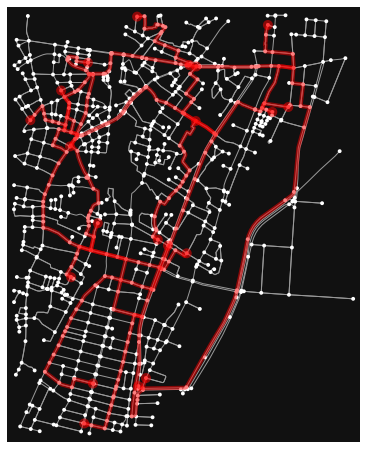

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdadabcacd0>)

In [ ]:
ox.plot_graph_routes(G, dw_answer_routes, route_alpha= 0.5)

実際にはこれではまだわかりにくいので、経路上を車が動くアニメーションなどを作成して、デモンストレーションすると良いでしょう。